In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import timedelta
from collections import Counter

In [2]:
data = pd.read_csv('web-traffic-time-series-forecasting/train_2.csv/train_2.csv').fillna(0)
data.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


In [3]:
print(data.shape)

(145063, 804)


In [ ]:
#Select only data up to 31/07/2017
date_cols = pd.to_datetime(data.columns[1:], errors="coerce")
train_mask = [True] + list(date_cols <= "2017-07-31")  # include first column
train = data.loc[:, train_mask]

train_dates = date_cols[date_cols <= "2017-07-31"]

In [44]:
test_mask = [True] + list((date_cols >= "2017-08-01") & (date_cols <= "2017-09-10"))
test = data.loc[:, test_mask]

test_dates = date_cols[(date_cols >= "2017-08-01") & (date_cols <= "2017-09-10")]

In [5]:
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-07-22,2017-07-23,2017-07-24,2017-07-25,2017-07-26,2017-07-27,2017-07-28,2017-07-29,2017-07-30,2017-07-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,12.0,20.0,16.0,31.0,19.0,14.0,20.0,13.0,22.0,14.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,16.0,11.0,44.0,18.0,13.0,12.0,8.0,21.0,15.0,14.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,5.0,8.0,2.0,3.0,3.0,2.0,5.0,7.0,4.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,7.0,15.0,19.0,9.0,10.0,11.0,21.0,14.0,13.0,13.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.0,8.0,9.0,7.0,10.0,3.0,14.0,4.0,4.0,15.0


In [45]:
test.head()

,Page,2017-08-01,2017-08-02,2017-08-03,2017-08-04,2017-08-05,2017-08-06,2017-08-07,2017-08-08,2017-08-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,20.0,46.0,24.0,22.0,22.0,11.0,25.0,45.0,39.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,18.0,39.0,20.0,31.0,19.0,7.0,11.0,20.0,13.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,0.0,22.0,8.0,4.0,3.0,1.0,3.0,7.0,3.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,14.0,37.0,14.0,12.0,13.0,11.0,10.0,14.0,15.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,14.0,40.0,39.0,66.0,114.0,19.0,29.0,12.0,11.0,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


C:\Users\arsen\AppData\Local\Temp\ipykernel_7460\212107106.py:23: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\arsen\AppData\Local\Temp\ipykernel_7460\212107106.py:23: UserWarning: Glyph 39791 (\N{CJK UNIFIED IDEOGRAPH-9B6F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\arsen\AppData\Local\Temp\ipykernel_7460\212107106.py:23: UserWarning: Glyph 38307 (\N{CJK UNIFIED IDEOGRAPH-95A3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\arsen\AppData\Local\Temp\ipykernel_7460\212107106.py:23: UserWarning: Glyph 33609 (\N{CJK UNIFIED IDEOGRAPH-8349}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\arsen\AppData\Local\Temp\ipykernel_7460\212107106.py:23: UserWarning: Glyph 34905 (\N{CJK UNIFIED IDEOGRAPH-8859}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\arsen\AppData\Local\Temp\ipykernel_7460\212107106.py:23: UserWarning: Glyph 36947 (\N{CJK UNIFIE

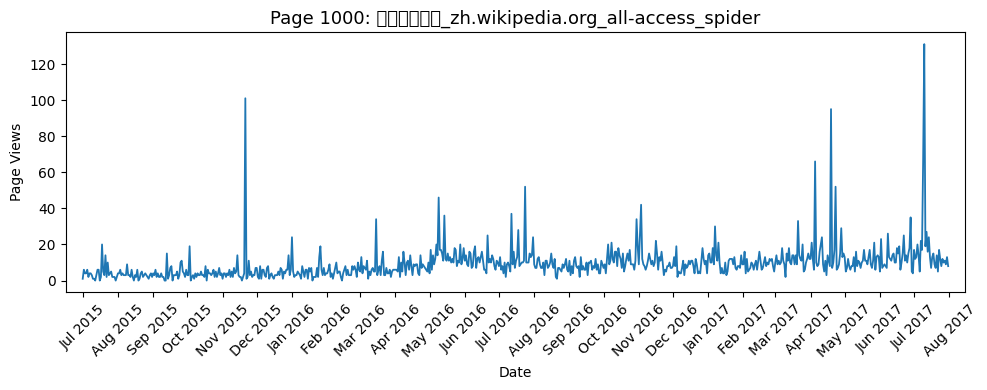

In [6]:

def plot_entry(idx):
    data = train.iloc[idx, 1:]  # Skip the 'Page' column, get all time series data
    page_name = train.iloc[idx, 0]   # Get the page name

    # Create the plot
    plt.figure(figsize=(10, 4))
    plt.plot(train_dates, data.values, linewidth=1.3)
    plt.title(f"Page {idx}: {page_name}", fontsize=13)
    plt.xlabel('Date')
    plt.ylabel('Page Views')
    #plt.grid(True, alpha=0.3)


    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

    plt.xticks(rotation=45)

    delta = timedelta(days=15)
    ax.set_xlim([train_dates.min() - delta, train_dates.max() + delta])

    plt.tight_layout()
    plt.show()

plot_entry(1000)



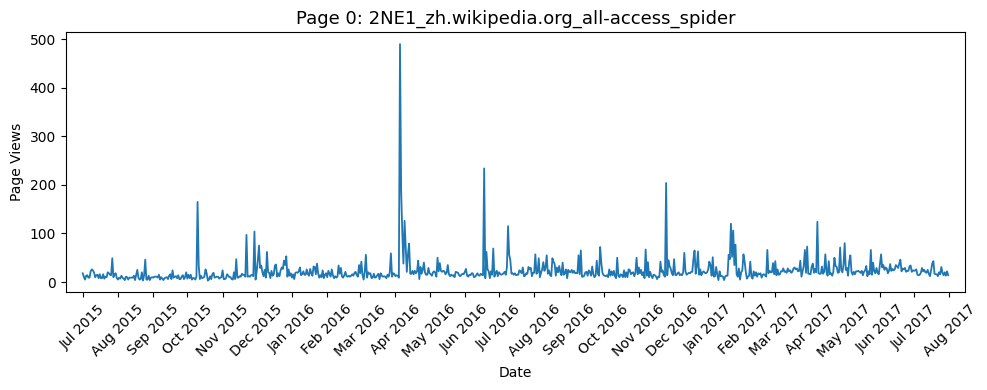

In [7]:
def plot_and_save_entry(idx):
    """
    Plot time series for a given index and save the image to plots folder
    
    Parameters:
    idx (int): Index of the row to plot
    """
    
    # Get the data and page name
    data = train.iloc[idx, 1:]  # Skip the 'Page' column, get all time series data
    page_name = train.iloc[idx, 0]   # Get the page name
    
    # Create the plot
    plt.figure(figsize=(10, 4))
    plt.plot(train_dates, data.values, linewidth=1.3)
    plt.title(f"Page {idx}: {page_name}", fontsize=13)
    plt.xlabel('Date')
    plt.ylabel('Page Views')

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

    plt.xticks(rotation=45)

    delta = timedelta(days=15)
    ax.set_xlim([train_dates.min() - delta, train_dates.max() + delta])

    plt.tight_layout()
    
    # Save the plot
    filename = f'plots/plot_{idx}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')


plot_and_save_entry(0)  # Plot and save the first time series

C:\Users\arsen\AppData\Local\Temp\ipykernel_17344\99696615.py:29: UserWarning: Glyph 39321 (\N{CJK UNIFIED IDEOGRAPH-9999}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\arsen\AppData\Local\Temp\ipykernel_17344\99696615.py:29: UserWarning: Glyph 21513 (\N{CJK UNIFIED IDEOGRAPH-5409}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\arsen\AppData\Local\Temp\ipykernel_17344\99696615.py:29: UserWarning: Glyph 22763 (\N{CJK UNIFIED IDEOGRAPH-58EB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\arsen\AppData\Local\Temp\ipykernel_17344\99696615.py:33: UserWarning: Glyph 39321 (\N{CJK UNIFIED IDEOGRAPH-9999}) missing from font(s) DejaVu Sans.
  plt.savefig(filename, dpi=300, bbox_inches='tight')
C:\Users\arsen\AppData\Local\Temp\ipykernel_17344\99696615.py:33: UserWarning: Glyph 21513 (\N{CJK UNIFIED IDEOGRAPH-5409}) missing from font(s) DejaVu Sans.
  plt.savefig(filename, dpi=300, bbox_inches='tight')
C:\Users\arsen\AppData\Local\Temp\ipyke

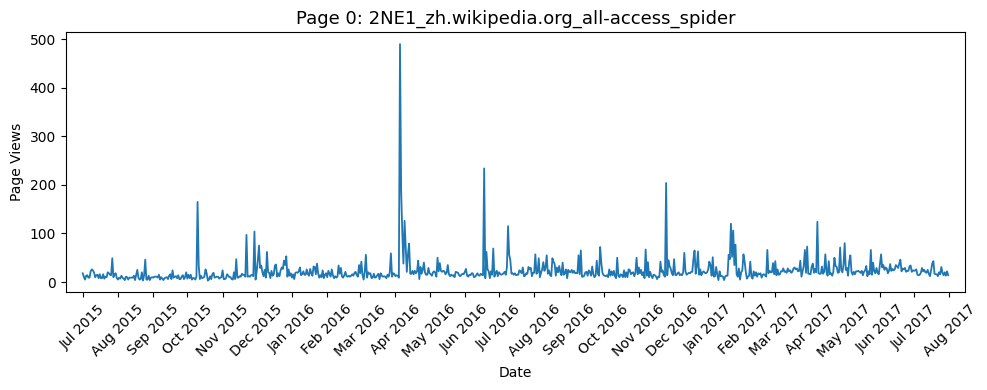

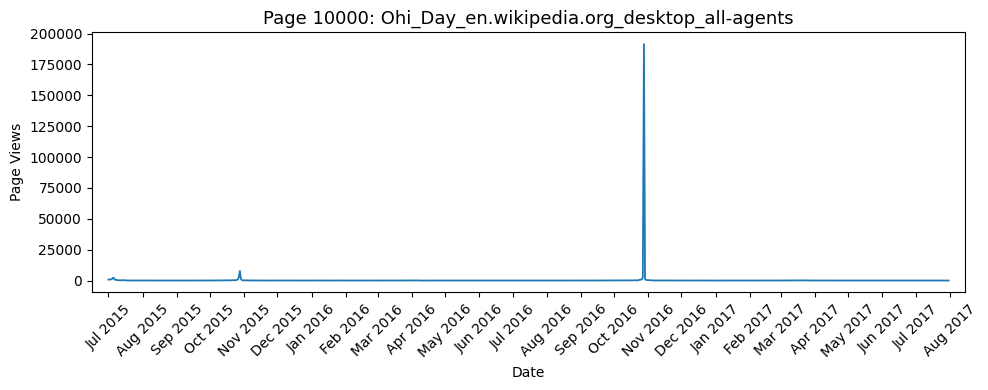

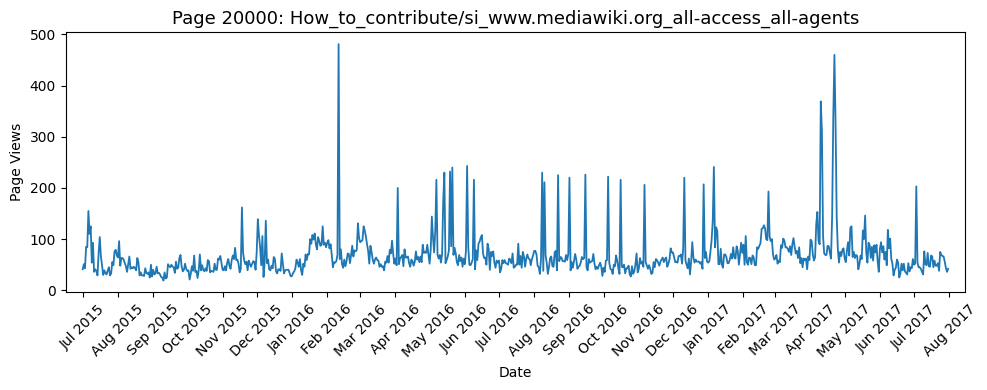

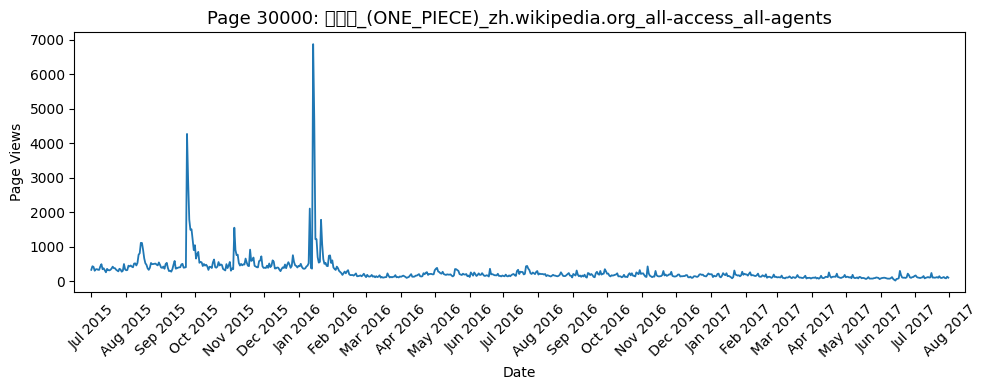

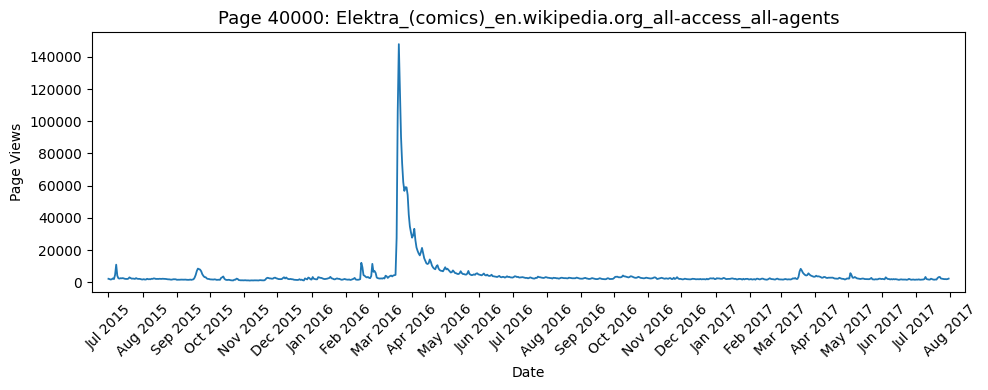

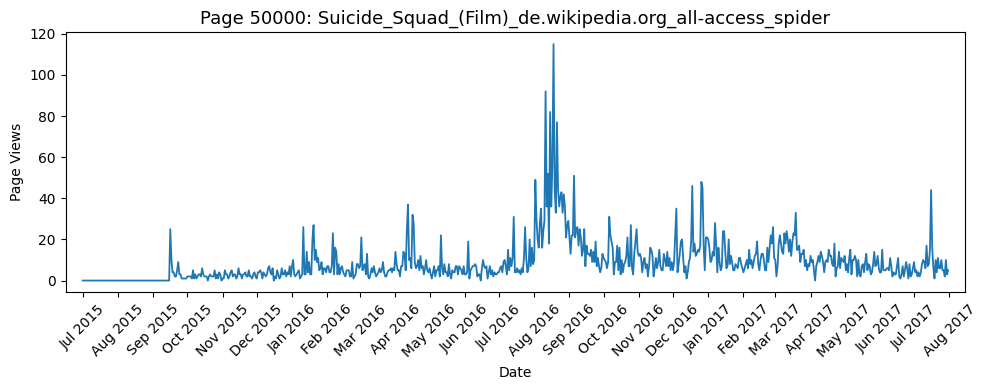

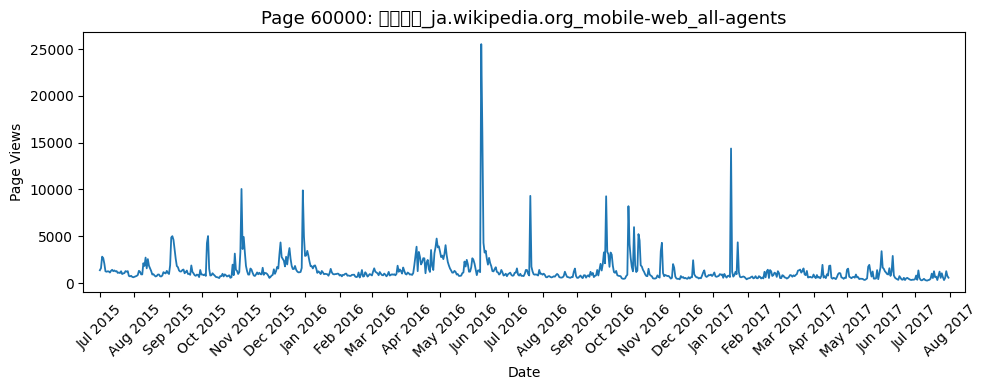

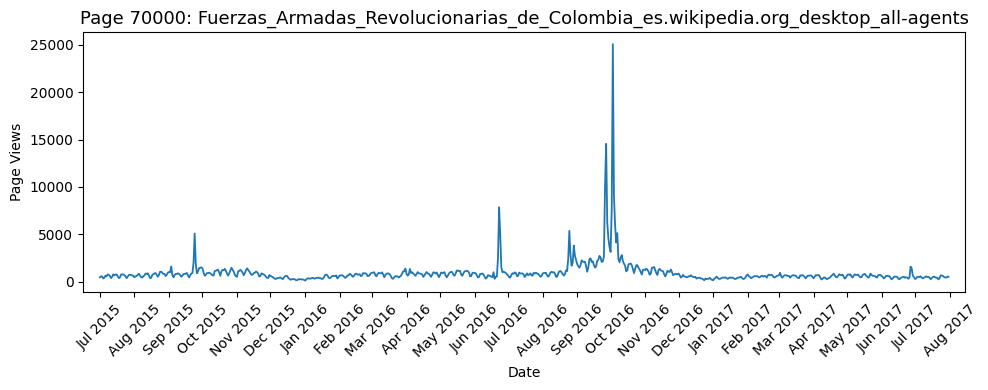

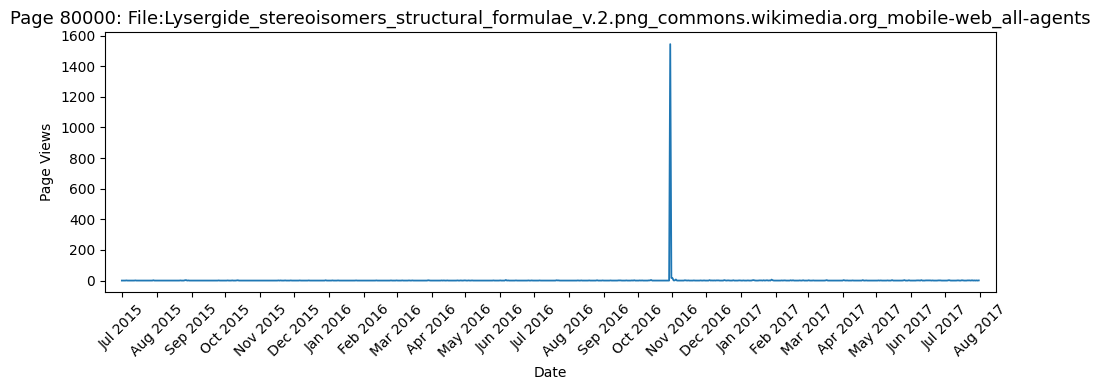

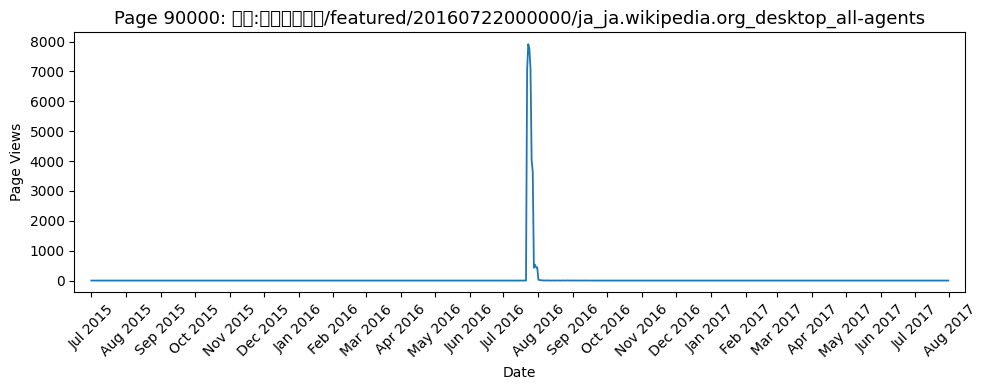

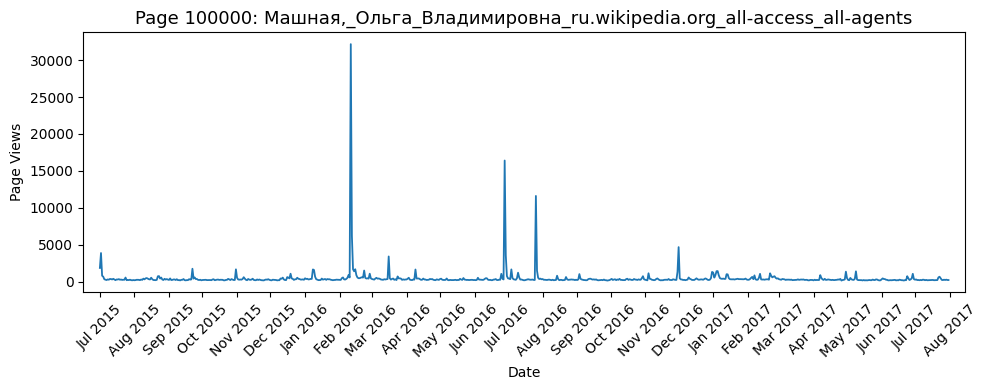

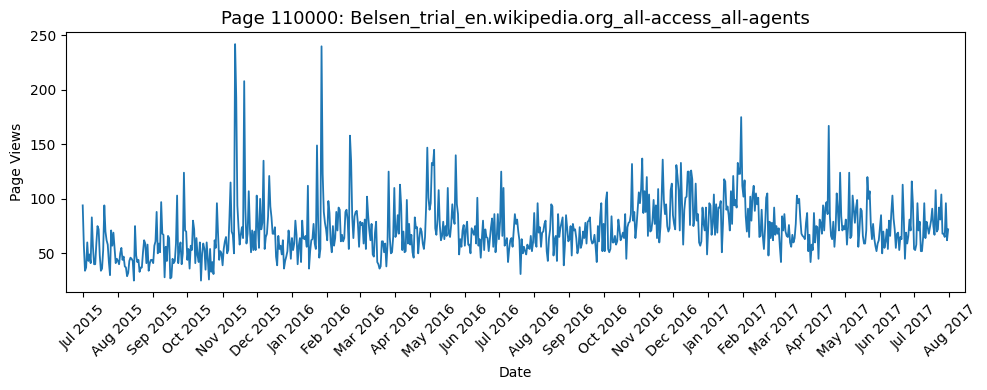

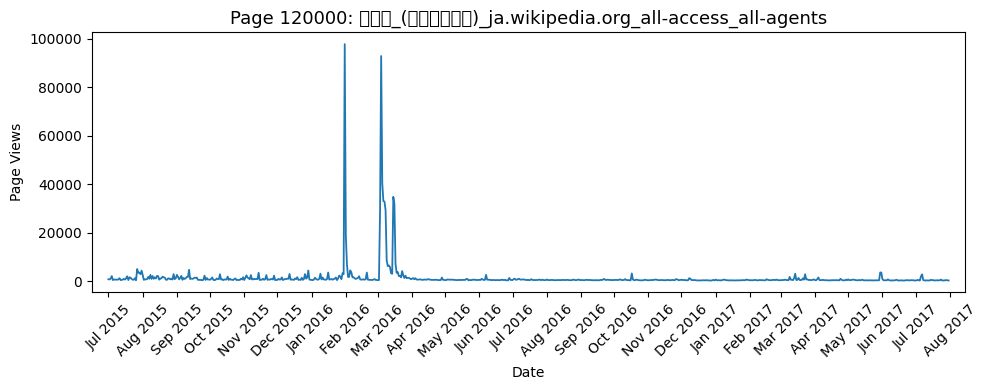

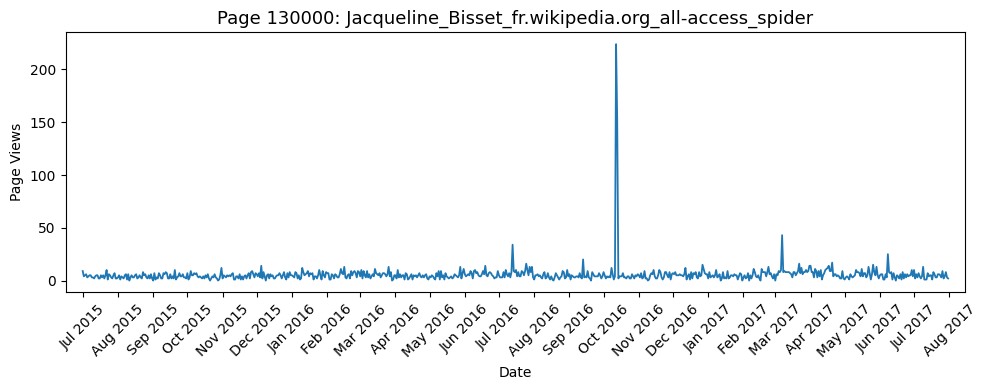

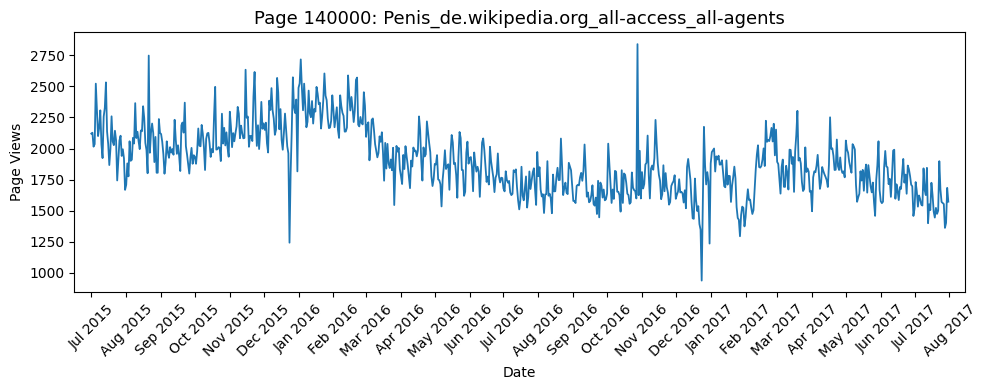

In [17]:
for i in range(0, 15):
    plot_and_save_entry(i*10000) 

In [48]:
def get_language(page):
    # Regex with a capturing group for the language code
    match = re.search(r'([a-z]{2})\.wikipedia\.org', page)
    if match:
        return match.group(1)  # get the captured language code
    return 'na'

train.loc[:, 'lang'] = train['Page'].map(get_language)

test.loc[:, 'lang'] = test['Page'].map(get_language)

print(Counter(train.lang))
print(Counter(test.lang))

Counter({'en': 24108, 'ja': 20431, 'de': 18547, 'na': 17855, 'fr': 17802, 'zh': 17229, 'ru': 15022, 'es': 14069})
Counter({'en': 24108, 'ja': 20431, 'de': 18547, 'na': 17855, 'fr': 17802, 'zh': 17229, 'ru': 15022, 'es': 14069})


In [9]:
lang_sets = {
    lang: train[train.lang == lang].iloc[:, 0:-1]
    for lang in train['lang'].unique()
}

avg_views_by_lang = {
    lang: df.iloc[:, 1:].sum(axis=0) / df.shape[0]
    for lang, df in lang_sets.items()
}

In [49]:
lang_sets_test = {
    lang: test[test.lang == lang].iloc[:, 0:-1]
    for lang in test['lang'].unique()
}

avg_views_by_lang_test = {
    lang: df.iloc[:, 1:].sum(axis=0) / df.shape[0]
    for lang, df in lang_sets_test.items()
}

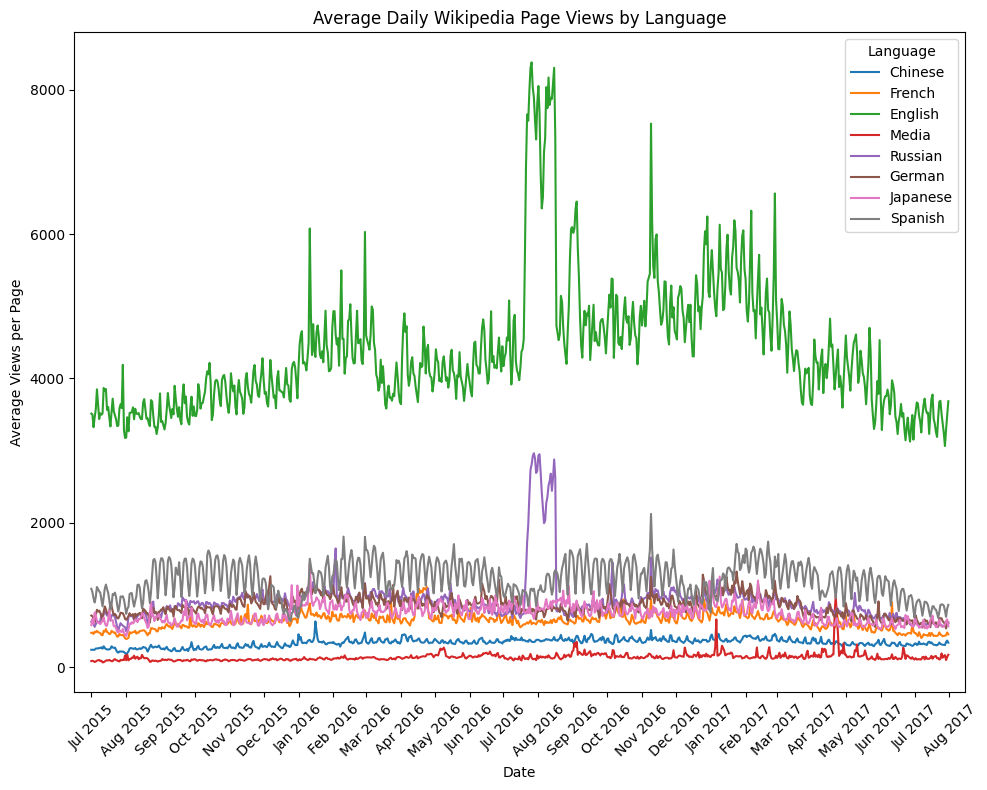

In [10]:
fig = plt.figure(figsize=[10,8])
plt.ylabel('Average Views per Page')
plt.xlabel('Date')
plt.title('Average Daily Wikipedia Page Views by Language')
labels={'en':'English','ja':'Japanese','de':'German',
        'na':'Media','fr':'French','zh':'Chinese',
        'ru':'Russian','es':'Spanish'
       }

for lang, series in avg_views_by_lang.items():
    plt.plot(train_dates, series.values, label=labels.get(lang, lang))

plt.legend(title='Language')

ax = plt.gca()

# Ticks at start of month
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation=45)

delta = timedelta(days=15)
ax.set_xlim([train_dates.min() - delta, train_dates.max() + delta])

plt.tight_layout()
plt.show()

In [11]:
for lang, series in avg_views_by_lang.items():
    avg_views_by_lang[lang].index = pd.to_datetime(series.index)

In [50]:
for lang, series in avg_views_by_lang_test.items():
    avg_views_by_lang_test[lang].index = pd.to_datetime(series.index)

In [24]:
def plot_and_save_lang(lang):
    """
    Plot average daily wikipedia page views for a given language and save the image to plots folder
    
    Parameters:
    lang (string): Language code
    """
    
    plt.figure(figsize=(10, 4))

    plt.ylabel('Average Views per Page')
    plt.xlabel('Date')
    plt.title(labels.get(lang, lang) + ' Wikipedia Subset: Average Daily Page Views')

    
    plt.plot(avg_views_by_lang[lang].index, avg_views_by_lang[lang].values)
   
    ax = plt.gca()

    # Ticks at start of month
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))


    plt.xticks(rotation=45)

    delta = timedelta(days=15)
    ax.set_xlim([train_dates.min() - delta, train_dates.max() + delta])

    plt.tight_layout()

    
    # Save the plot
    filename = f'plots/plot_{lang}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')

    plt.show()



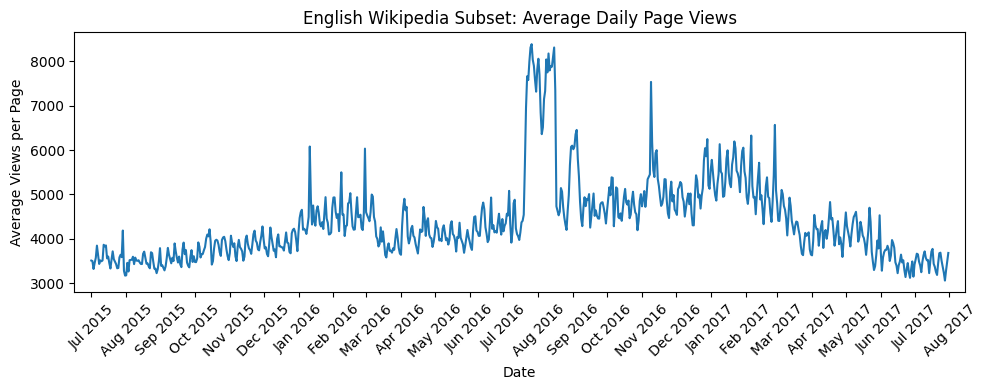

In [25]:
plot_and_save_lang('en')

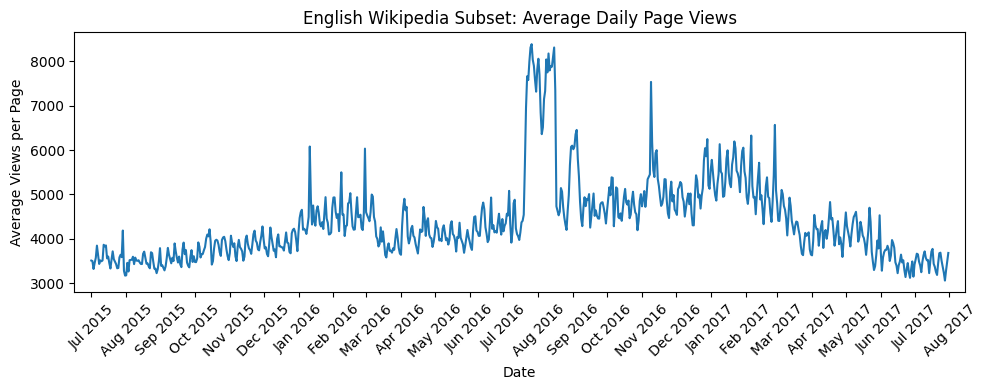

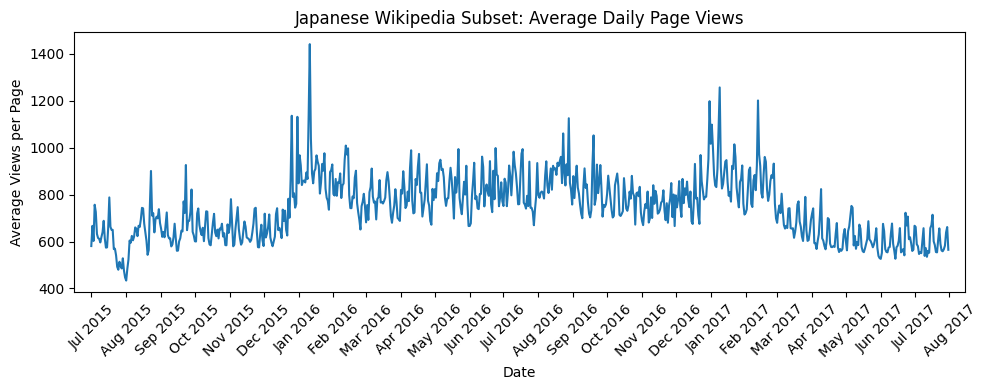

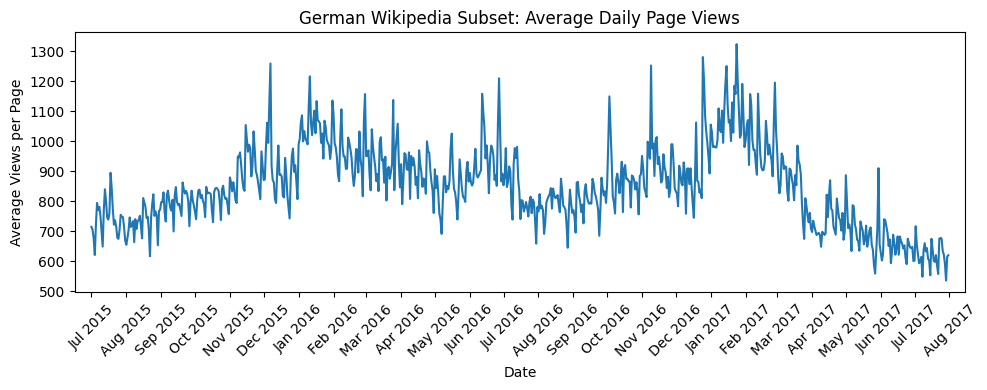

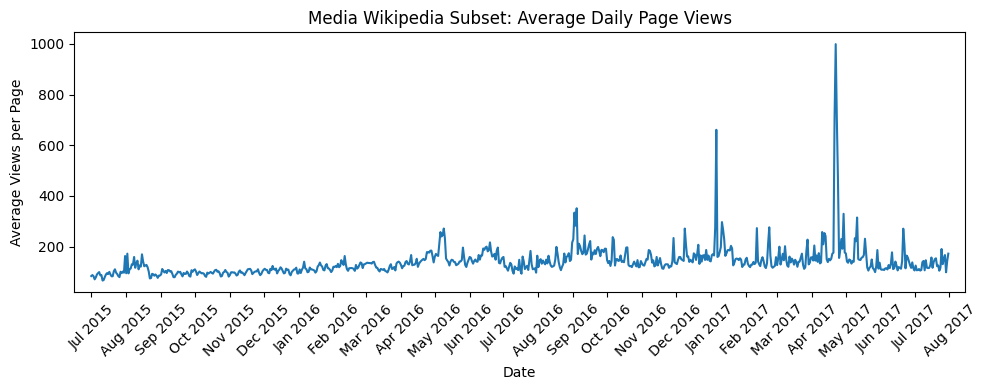

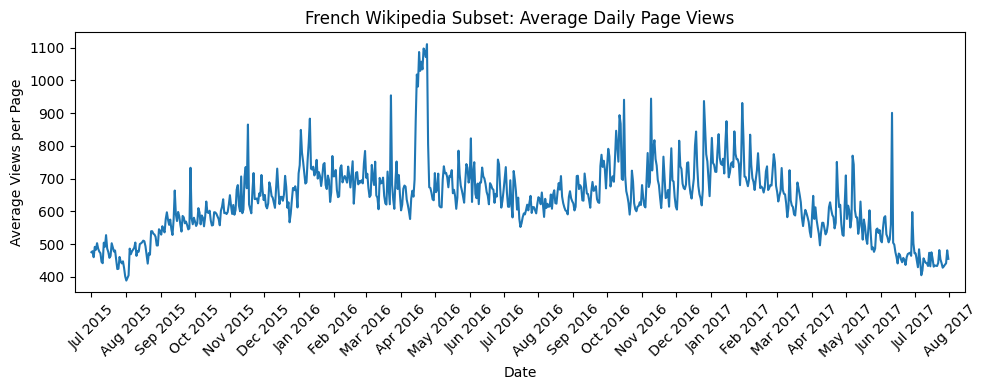

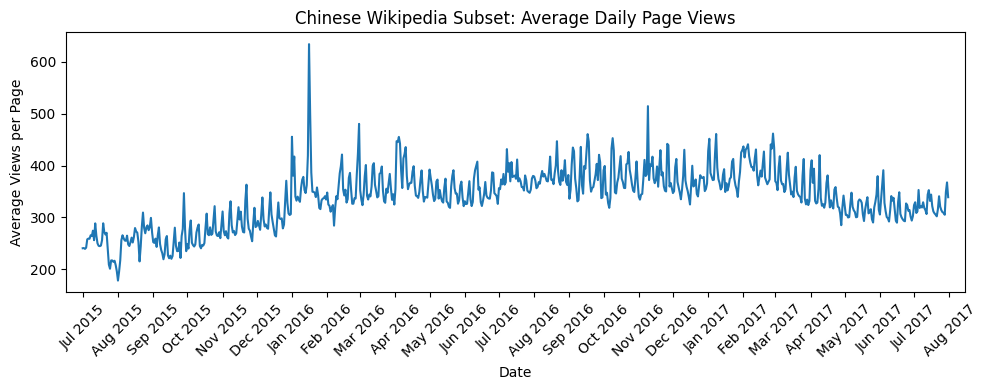

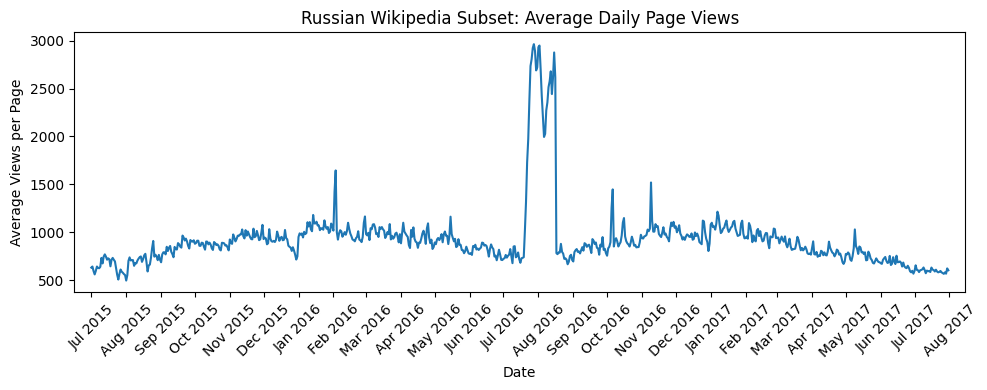

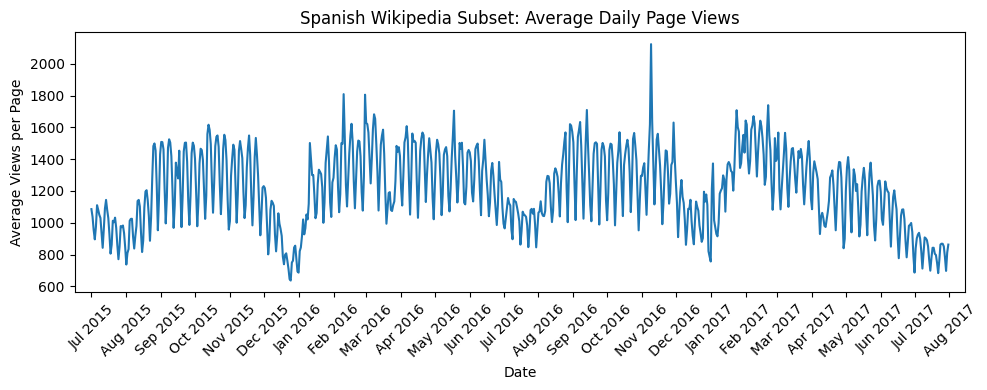

In [26]:
for lang in labels.keys():
    plot_and_save_lang(lang)

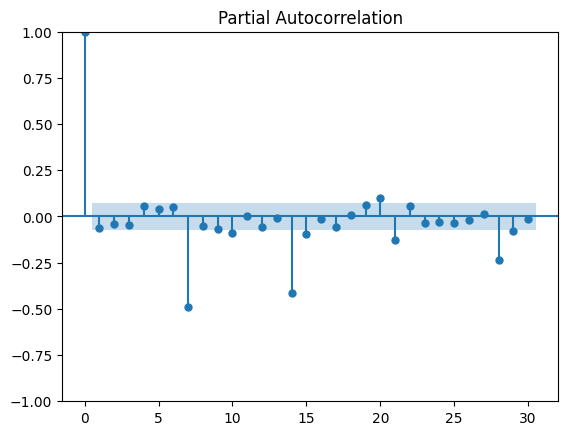

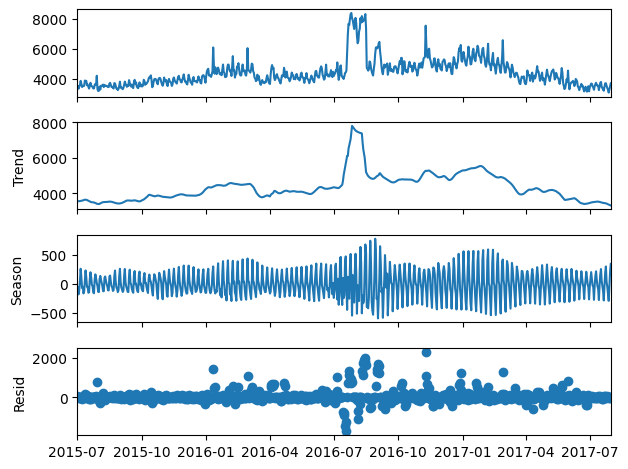

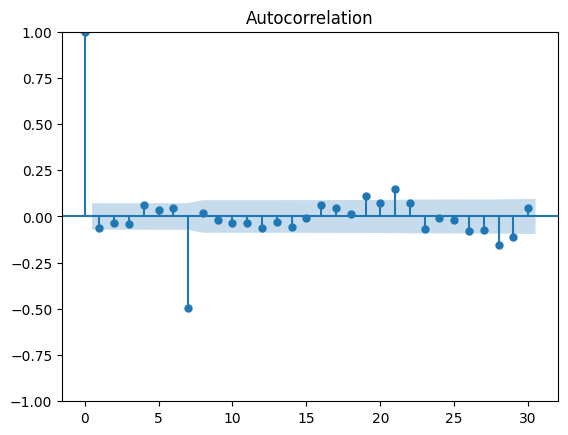

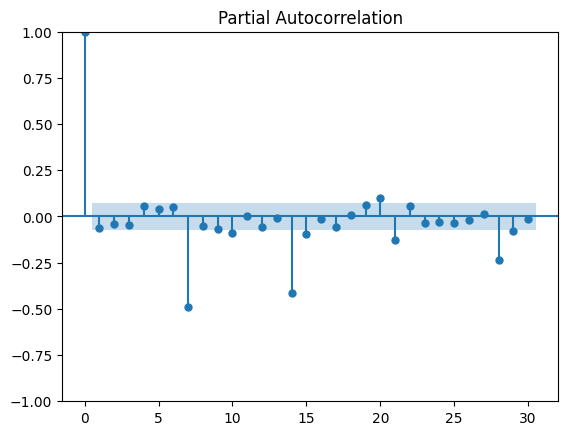

In [52]:
series = avg_views_by_lang["en"]
series_test = avg_views_by_lang_test["en"]

stl = STL(series, period=7, robust=True)
res = stl.fit()
res.plot()

series_diff1 = series.diff(periods=1)
series_diff1_7 = series_diff1.diff(periods=7)



plot_acf(series_diff1_7.dropna(), lags=30)
plot_pacf(series_diff1_7.dropna(), lags=30)

d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


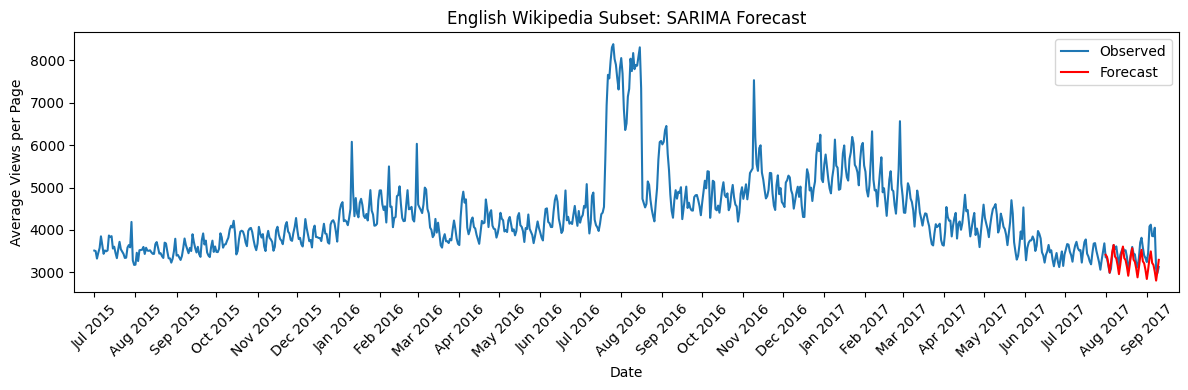

In [57]:
# Fit SARIMA model
model = SARIMAX(series, order=(1,1,1), seasonal_order=(2,1,1,7))
fit = model.fit()

# Forecast next 30 days
forecast = fit.forecast(steps=41)

series_combined = pd.concat([series, series_test])

# Plot forecast vs. history
plt.figure(figsize=(12,4))
plt.plot(series_combined.index, series_combined, label="Observed", color='C0')
plt.plot(forecast.index, forecast, label="Forecast", color="red")
plt.legend()
plt.ylabel('Average Views per Page')
plt.xlabel('Date')
plt.title('English Wikipedia Subset: SARIMA Forecast')

ax = plt.gca()

ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation=45)

delta = timedelta(days=15)
ax.set_xlim([train_dates.min() - delta, forecast.index.max() + delta])


plt.tight_layout()
plt.show()



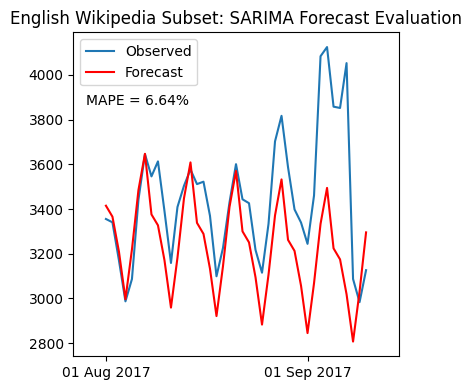

In [74]:
mape = np.mean(np.abs((series_test - forecast) / series_test)) * 100

plt.figure(figsize=(4,4))
plt.plot(series_test.index, series_test, label="Observed")
plt.plot(forecast.index, forecast, label=f"Forecast", color="red")
plt.legend()
plt.title('English Wikipedia Subset: SARIMA Forecast Evaluation')


ax = plt.gca()

ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))  # show day + month + year

#plt.xticks(rotation=45)

delta = timedelta(days=5)
ax.set_xlim([series_test.index.min() - delta, series_test.index.max() + delta])

plt.text(
    0.04, 0.81,                     # position in axes coordinates (left, top)
    f"MAPE = {mape:.2f}%",          # text
    transform=ax.transAxes,          # use axes coordinates
    verticalalignment='top'
)


plt.tight_layout()
plt.show()


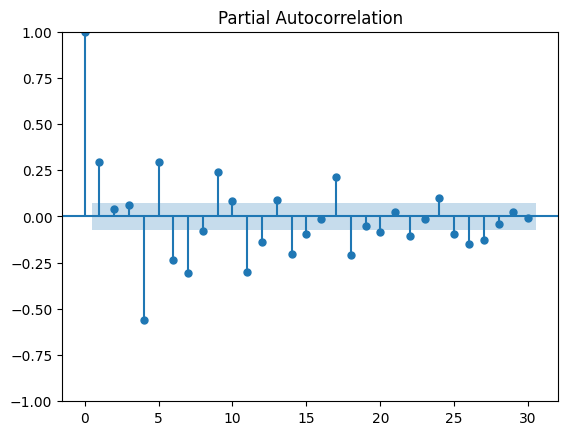

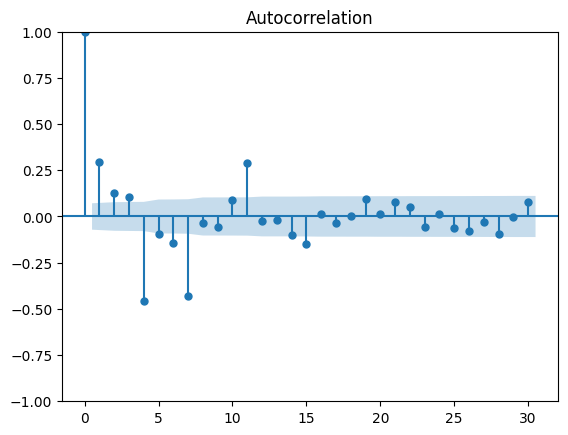

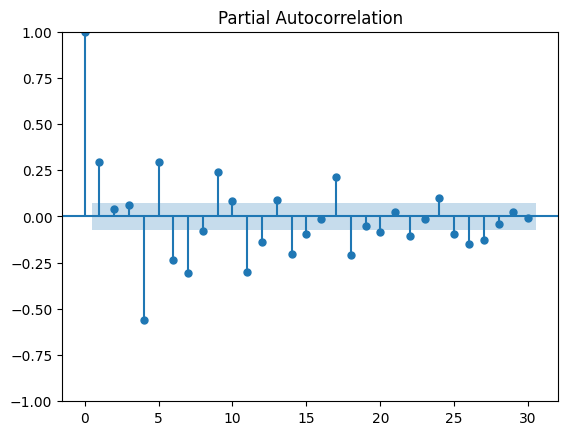

In [80]:
series = avg_views_by_lang["ja"]
series_test = avg_views_by_lang_test["ja"]


series_diff7 = series.diff(periods=7)

series_diff7_4 = series_diff7.diff(periods=4)

plot_acf(series_diff7_4.dropna(), lags=30)
plot_pacf(series_diff7_4.dropna(), lags=30)

# plot_acf(series_diff7.dropna(), lags=30)
# plot_pacf(series_diff7.dropna(), lags=30)

# series_diff1 = series.diff(periods=1)
# series_diff1_7 = series_diff1.diff(periods=7)



# plot_acf(series_diff1_7.dropna(), lags=30)
# plot_pacf(series_diff1_7.dropna(), lags=30)